# 2 - Gràfics de sèries temporals amb Datashader


## Instal·lació de Datashader en Google Colab

Ja hem vist que podem instal·lar Datashader amb PIP.

In [ ]:
!pip install datashader

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 49.2 MB/s eta 0:00:00


## Creació de dades sintètiques de sèries temporals

Per a aquets exemple, anam a crear un dataframe amb 3 columnes que contenen 3 sèries temporals de 100.000 valors cada una. Aquestes sèries simulen les lectures d'uns sensors que es van llegint cada minut.

Per fer aquestes sèries, partirem d'un senyal que segueix una distribució normal amb mitjana 0 i desviació típica 0,3 i a la que sumam 50. Aquest senyal el guardam a les 3 sèries.

A continuació, a les 3 sèries els afegim un renou, les dues primeres amb un renou suau molt similar, la 3a amb un renou molt més fort.

Per fer-ho més realista, a la primera sèrie li afegim 10 outliers.

I afegirem també una 4a columna al dataframe amb marca temporal (datetime) de cada valor. Començam des de l'1 de gener de 2024 a les 0:00 i, per a cada valor de les sèries, l'anam incrementam en un minut.

Datashader no treballa amb datetimes, sinó amb la seva representació en enters. Per això afegim una 5a columna que conté la representació en enters dels datatime de la 4a columna.

In [ ]:
import datetime
import pandas as pd
import numpy as np

# Definim algunes constants
np.random.seed(99) # Fixam la llavor per poder reproduir l'experiment
n = 100000 # Nombre d'elements de cada sèrie
cols = ["serie_1", "serie_2", "serie_3"]  # Nom de les 3 columnes
inici = datetime.datetime(2024, 1, 1) # Moment inicial (1/1/2024)

# Generació del senyal sintètic a partir d'una normal
signal = np.random.normal(0, 0.3, size=n).cumsum() + 50

# Afegim renou al senyal
noise = lambda var, bias, n: np.random.normal(bias, var, n)
data = {c: signal + noise(1, 10*(np.random.random() - 0.5), n) for c in cols}

# Afegim més renou encara a la sèrie 3
data["serie_3"] = data["serie_3"] + np.random.normal(0, 0.2, size=n).cumsum() # Aquesta mostra té un renou molt diferent

# Afegim 10 outliers en la 1a sèrie
locs = np.random.choice(n, 10)
data['serie_1'][locs] *= 2

# Afegim la data d'observació (datetime)
data['data'] = [inici + datetime.timedelta(minutes=1)*i for i in range(n)]

# Afegim el valor enter de la data
data['data_int'] = pd.to_datetime(data['data']).astype('int64')

# Cream el dataframe
df = pd.DataFrame(data)

df.head()

,serie_1,serie_2,serie_3,data,data_int
0,54.111219,51.376391,47.689372,2024-01-01 00:00:00,1704067200000000000
1,53.842293,52.051051,49.223422,2024-01-01 00:01:00,1704067260000000000
2,55.972022,51.072260,48.958593,2024-01-01 00:02:00,1704067320000000000
3,55.634865,52.941958,48.493715,2024-01-01 00:03:00,1704067380000000000
4,55.341890,53.264477,48.753009,2024-01-01 00:04:00,1704067440000000000


In [ ]:
# Definim el rang en els eixos x (temps) i y (valor de les mostres sintètique) per al plot
x_range = (df.iloc[0].data_int, df.iloc[-1].data_int)
y_range = (0.5*signal.min(), 1.5*signal.max()) #ampliam el rang per veure-ho bé

print("x_range: {0} y_range: {1}".format(x_range,y_range))

x_range: (1704067200000000000, 1710067140000000000) y_range: (8.602920888225452, 235.57491372303608)


## Representar tots els punts de la sèrie 1

CPU times: user 4.04 s, sys: 79.6 ms, total: 4.12 s
Wall time: 5 s


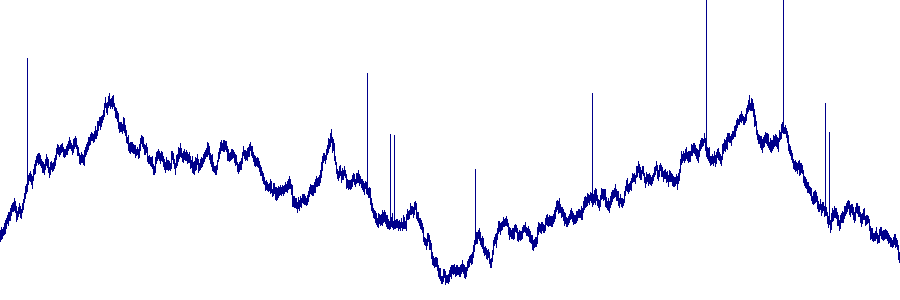

In [ ]:
import datashader as ds
import datashader.transfer_functions as tf

# Definim el canvas (llenç, lienzo) on dibuixarem els nostres gràfics
cvs = ds.Canvas(x_range=x_range, y_range=y_range, plot_height=300, plot_width=900)

# Utilitzam cvs.line(dataframe, eix x, eix y) per dibuixar la sèrie
# Amb %time podem saber el temps d'execució
%time tf.shade(cvs.line(df, "data_int", "serie_1"))

**Per què és important emprar biblioteques com Datashader que permetin representar totes les dades?**

Perquè amb altres llibreries no podem representar sèries tan grans i és necessari fer un mostreig (agafar un subconjunt dels valors de la sèrie), la qual cosa pot suposar pèrdues d'informació.

Per exemple, el següent codi dibuixa només un de cada 10 valors de la sèrie. Podem observar com es perden 8 dels 10 outliers que tenim (que en el gràfic anterior sí podíem detectar clarament).

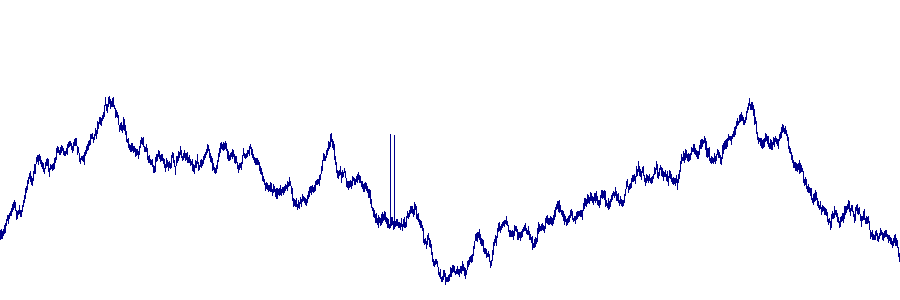

In [ ]:
mask = (df.index % 10) == 0
tf.shade(cvs.line(df[mask][["data_int", "serie_1"]], "data_int", "serie_1"))

## Representar tots els punts de les sèries 1, 2 i 3 superposades

In [ ]:
# Amb %time al principi de la cel·la podem saber el temps d'execució de tota la cel·la
%%time
from collections import OrderedDict

cvs = ds.Canvas(x_range=x_range, y_range=y_range, plot_height=300, plot_width=900)
aggs = OrderedDict((c, cvs.line(df, 'data_int', c)) for c in cols)

CPU times: user 4.57 s, sys: 25.9 ms, total: 4.6 s
Wall time: 5.7 s


In [ ]:
# Vegem que tenim dins aggs per a la 1a sèrie
aggs["serie_1"]

<xarray.DataArray (serie_1: 300, data_int: 900)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * data_int  (data_int) float64 1.704e+18 1.704e+18 ... 1.71e+18 1.71e+18
  * serie_1   (serie_1) float64 8.981 9.738 10.49 11.25 ... 233.7 234.4 235.2
Attributes:
    x_range:  (1704067200000000000, 1710067140000000000)
    y_range:  (8.602920888225452, 235.57491372303608)

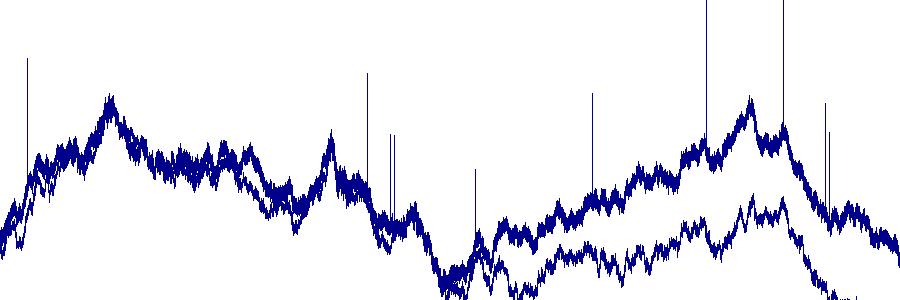

In [ ]:
# Dibuixam totes les sèries (les 3 columnes del dataframe)
import xarray as xr

renamed = [aggs[key].rename({key: 'valor'}) for key in aggs]
merged = xr.concat(renamed, 'cols')
tf.shade(merged.any(dim='cols'))

Aquí hem usat l'operador *any*, que fusiona totes les dades de forma que qualsevol píxel "il·luminat" per a qualsevol sèrie, "s'il·lumina" en el resultat final. Clarament, és difícil veure qualsevol estructura en aquestes dades, que queden completament sobreimpreses.

Anam ara a pintar d'un color distint cada una de les tres sèries.

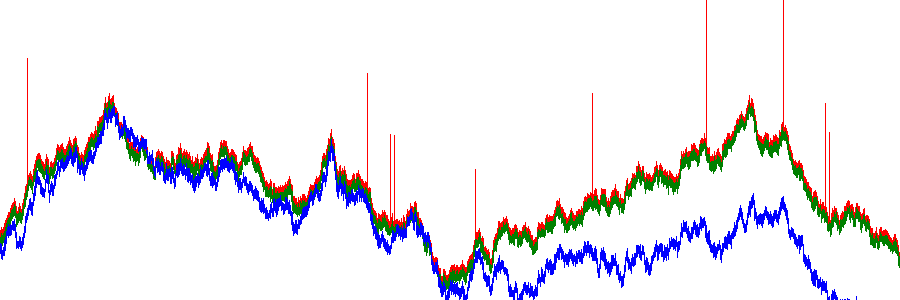

In [ ]:
colors = ["red", "green", "blue"]
imgs = [tf.shade(aggs[i], cmap=[c]) for i, c in zip(cols, colors)]
tf.stack(*imgs)

En lloc de l'operador *.any()* anterior, també és interessant l'ús de l'operador *.sum()* per a mostrar els patrons de solapament: a més sèries solapades, més fosca és la línia.

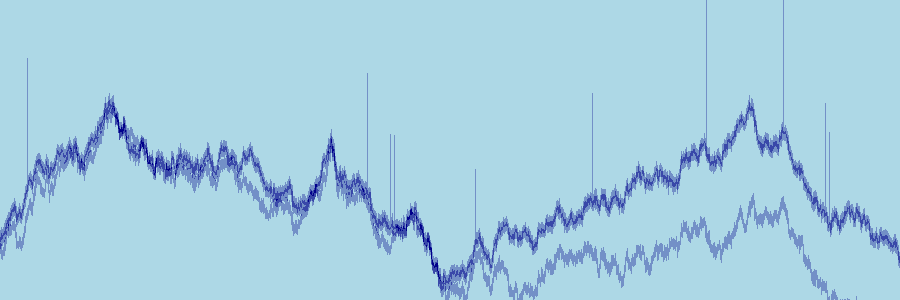

In [ ]:
tf.shade(merged.sum(dim='cols'), how='linear')